In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [7]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 2: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 3: # 6:2:2
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)

  return train_data, test_data, val_data


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/NFLX_Stock.csv',usecols=['Date', 'Price'], parse_dates=['Date'])
df

,Date,Price
0,2017-12-01,186.82
1,2017-12-04,184.04
2,2017-12-05,184.21
3,2017-12-06,185.30
4,2017-12-07,185.20
...,...,...
1387,2023-06-08,409.37
1388,2023-06-09,420.02
1389,2023-06-12,423.97
1390,2023-06-13,435.73


In [9]:
df = df.groupby('Date').sum()
df

,Price
Date,
2017-12-01,186.82
2017-12-04,184.04
2017-12-05,184.21
2017-12-06,185.30
2017-12-07,185.20
...,...
2023-06-08,409.37
2023-06-09,420.02
2023-06-12,423.97


<Axes: title={'center': 'Price of Close'}, xlabel='Date'>

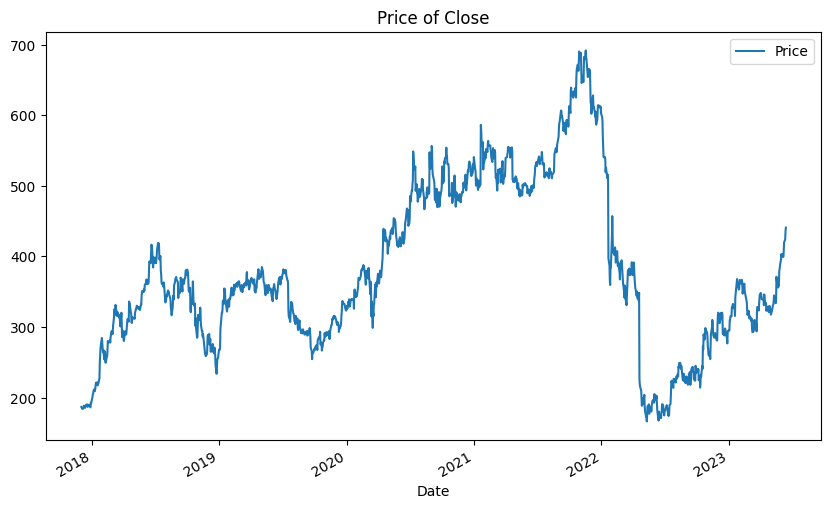

In [10]:
df[['Price']].plot(title='Price of Close', figsize=(10,6))

<Axes: title={'center': 'Price of Close'}, xlabel='Date'>

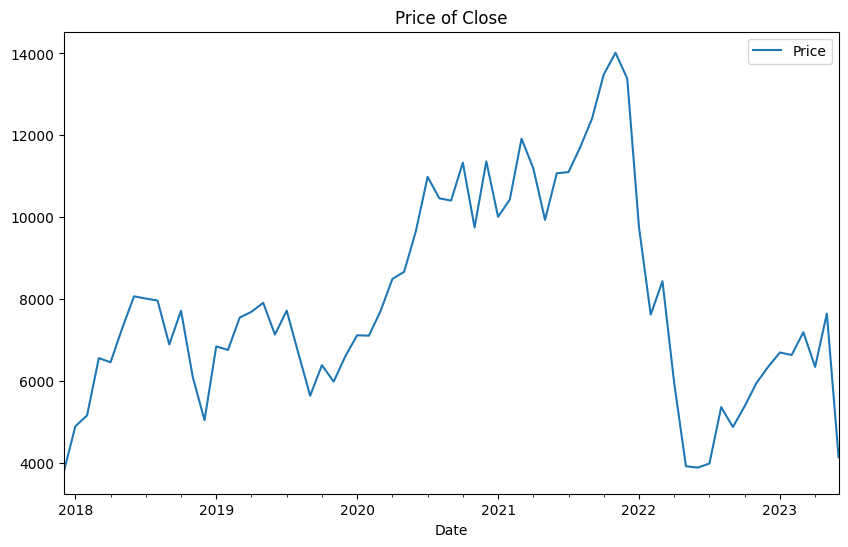

In [11]:
#re-sampling the data to monthly buckets
#daily> monthyly


df = df.resample(rule='M').sum()
df[['Price']].plot(title='Price of Close', figsize=(10,6))

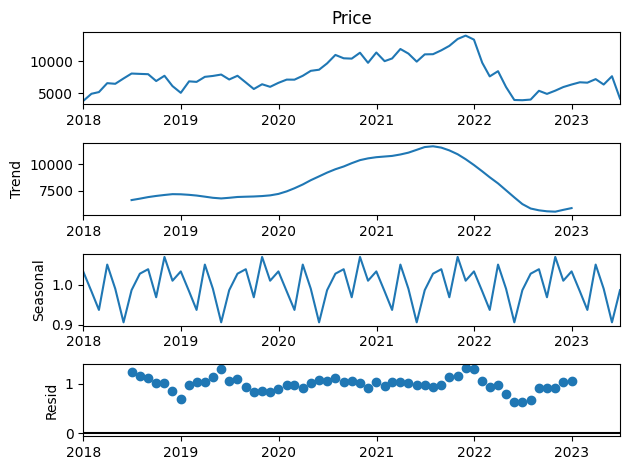

In [12]:
decompose_result = seasonal_decompose(df['Price'],model='multiplicative', period=12)
plt.figsize=(10,6)
decompose_result.plot()
plt.show()

In [13]:
train_data, test_data, val_data = split_data(df, 1)

Train:  46
Test:  13
Val:  8


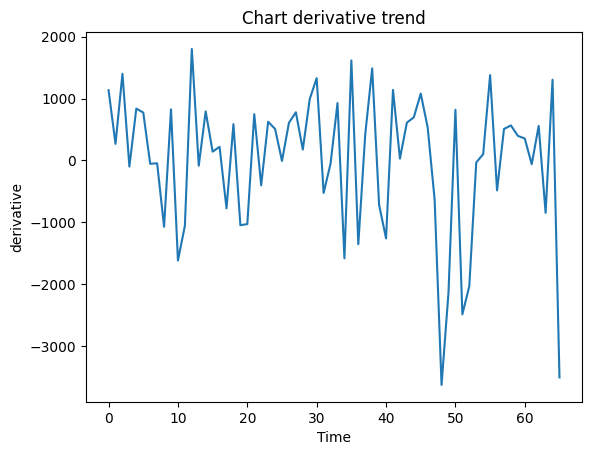

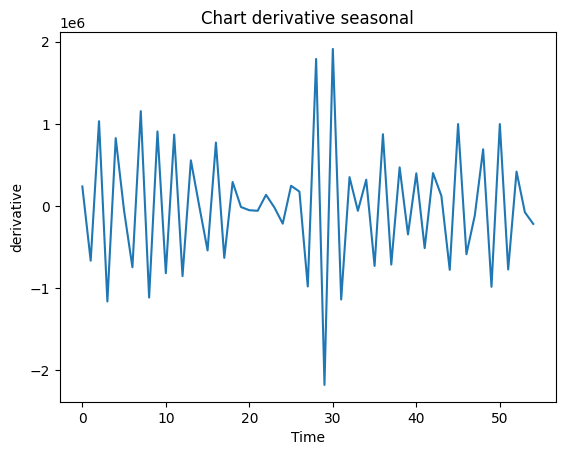

In [14]:
# Kiểm tra trend và seasonal của dữ liệu
diff = np.diff(df['Price'])
seasonal_diff = np.diff(df['Price'], 12)  # Giả sử một chu kỳ mùa vụ có độ dài 12

plt.plot(diff)
plt.xlabel('Time')
plt.ylabel('derivative')
plt.title('Chart derivative trend')
plt.show()

plt.plot(seasonal_diff)
plt.xlabel('Time')
plt.ylabel('derivative')
plt.title('Chart derivative seasonal')
plt.show()

# Quyết định loại tham số
trend_type = 'add' if np.mean(diff) >= 0 else 'mul'
seasonal_type = 'add' if np.mean(seasonal_diff) >= 0 else 'mul'


In [15]:
trend_type, seasonal_type

('add', 'mul')

In [16]:
model = ExponentialSmoothing(train_data['Price'], trend=trend_type, seasonal=seasonal_type, seasonal_periods=12)
model_fit = model.fit(optimized=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [17]:
def mae_rmse_mape(true, predict):
  mae = mean_absolute_error(true, predict)
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return mae, rmse, mape

In [18]:
test_pred = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
val_pred = model_fit.predict(start=val_data.index[0], end=val_data.index[-1])

In [19]:
val_pred

2022-11-30    11660.373610
2022-12-31    11175.753301
2023-01-31    13261.360151
2023-02-28    13018.423672
2023-03-31    14192.157526
2023-04-30    14817.985640
2023-05-31    15008.906741
2023-06-30    15871.836819
Freq: M, dtype: float64

In [20]:
val_data['Price']

Date
2022-11-30    5946.61
2022-12-31    6342.88
2023-01-31    6695.18
2023-02-28    6632.86
2023-03-31    7189.87
2023-04-30    6341.13
2023-05-31    7644.12
2023-06-30    4136.15
Freq: M, Name: Price, dtype: float64

In [21]:
mae_test, rmse_test, mape_test = mae_rmse_mape(test_data['Price'], test_pred)
mae_val, rmse_val, mape_val = mae_rmse_mape(val_data['Price'], val_pred)

print('MAE of Test: ', mae_test)
print('RMSE of Test: ', rmse_test)
print('MAPE of Test: ', mape_test)
print('------------------------')
print('MAE of Validation: ', mae_val)
print('RMSE of Validation: ', rmse_val)
print('MAPE of Validation: ', mape_val)

MAE of Test:  6589.791006039745
RMSE of Test:  7493.016860006427
MAPE of Test:  1.2865536077368662
------------------------
MAE of Validation:  7259.749682540969
RMSE of Validation:  7522.8771517487085
MAPE of Validation:  1.2222185249843427


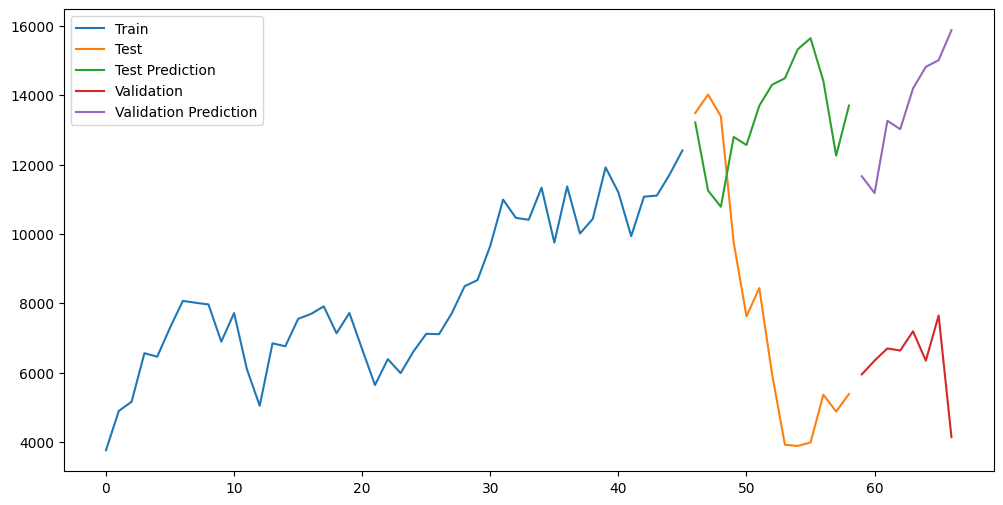

In [22]:
plt.figure(figsize=(12,6))

plt.plot(range(len(train_data)), train_data['Price'], label='Train')

plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data['Price'], label='Test')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_pred, label='Test Prediction')

plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_data['Price'], label='Validation')
plt.plot(range(len(train_data) + len(test_data), len(train_data) + len(test_data) + len(val_data)), val_pred, label='Validation Prediction')


plt.legend()
plt.show()

<Axes: xlabel='Date'>

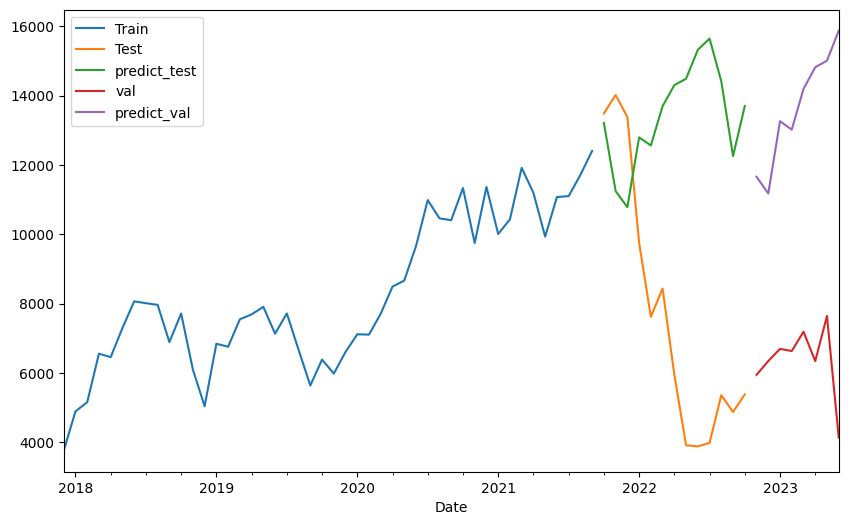

In [23]:
train_data['Price'].plot(legend=True, label='Train', figsize=(10,6))

test_data['Price'].plot(legend=True, label='Test')
test_pred.plot(legend=True, label='predict_test')

val_data['Price'].plot(legend=True, label='val')
val_pred.plot(legend=True, label='predict_val')

# forecast_start = val_data.index[-1] + pd.DateOffset(months=1)
# forecast_end = forecast_start + pd.DateOffset(months=11)
# forecast_30months = model_fit.predict(start=forecast_start, end=forecast_end)
# forecast_30months.plot(legend=True, label='3 months')